<a href="https://colab.research.google.com/github/nitin-barthwal/TextAnalytics/blob/master/TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Latent Semantic Analysis (LSA)**
All languages have their own intricacies and nuances which are quite difficult for a machine to capture (sometimes they’re even misunderstood by us humans!). This can include different words that mean the same thing, and also the words which have the same spelling but different meanings.


Steps involved in the implementation of LSA
Let’s say we have m number of text documents with n number of total unique terms (words). We wish to extract k topics from all the text data in the documents. The number of topics, k, has to be specified by the user.

Generate a document-term matrix of shape m x n having **TF-IDF scores**.
Then, we will reduce the dimensions of the above matrix to k (no. of desired topics) dimensions, using singular-value decomposition (SVD).
SVD decomposes a matrix into three other matrices. Suppose we want to decompose a matrix A using SVD. It will be decomposed into matrix U, matrix S, and VT (transpose of matrix V).Each row of the matrix Uk (document-term matrix) is the vector representation of the corresponding document. The length of these vectors is k, which is the number of desired topics. Vector representation for the terms in our data can be found in the matrix Vk (term-topic matrix).

So, **SVD** gives us vectors for every document and term in our data. The length of each vector would be k. We can then use these vectors to find similar words and similar documents using the cosine similarity method.
 

![alt text](https://raw.githubusercontent.com/nitin-barthwal/TextAnalytics/master/Screenshot_2.png)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#testing if GPU backend enabled for notebook
import tensorflow as tf
tf.test.gpu_device_name()

pd.set_option("display.max_colwidth", 200)

In [2]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=1, random_state =1, remove=('headers','footers','quotes'))
documents = dataset.data
#len(documents)
#datasets.taget_names

**Data Preprocessing**

To start with, we will try to clean our text data as much as possible. The idea is to remove the punctuations, numbers, and special characters all in one step using the regex replace(“[^a-zA-Z#]”, ” “), which will replace everything, except alphabets with space. Then we will remove shorter words because they usually don’t contain useful information. Finally, we will make all the text lowercase to nullify case sensitivity.

In [3]:
news_df = pd.DataFrame({'documents':documents})

#Removing everything except alphabets
news_df['clean_doc'] = news_df["documents"].str.replace("[^a-zA-Z#]"," ");

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x:x.lower())

news_df['clean_doc']

0        well sure about story seem biased what disagree with your statement that media ruin israels reputation that rediculous media most israeli media world having lived europe realize that incidences su...
1        yeah expect people read actually accept hard atheism need little leap faith jimmy your logic runs steam sorry pity sorry that have these feelings denial about faith need well just pretend that wil...
2        although realize that principle your strongest points would still like know question this sort about arab countries want continue this think tank charade yours your fixation israel must stop might...
3        notwithstanding legitimate fuss about this proposal much change last product this area priced over suspect clipper phones will came customer with automatically preregistered with government author...
4        well will have change scoring playoff pool unfortunately have time right will certainly post scoring rules tomorrow does matter enter anyway good keith kel

In [4]:
news_df['clean_doc']

0        well sure about story seem biased what disagree with your statement that media ruin israels reputation that rediculous media most israeli media world having lived europe realize that incidences su...
1        yeah expect people read actually accept hard atheism need little leap faith jimmy your logic runs steam sorry pity sorry that have these feelings denial about faith need well just pretend that wil...
2        although realize that principle your strongest points would still like know question this sort about arab countries want continue this think tank charade yours your fixation israel must stop might...
3        notwithstanding legitimate fuss about this proposal much change last product this area priced over suspect clipper phones will came customer with automatically preregistered with government author...
4        well will have change scoring playoff pool unfortunately have time right will certainly post scoring rules tomorrow does matter enter anyway good keith kel

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

It’s good practice to remove the stop-words from the text data as they are mostly clutter and hardly carry any information. Stop-words are terms like ‘it’, ‘they’, ‘am’, ‘been’, ‘about’, ‘because’, ‘while’, etc.

To remove stop-words from the documents, we will have to tokenize the text, i.e., split the string of text into individual tokens or words. We will stitch the tokens back together once we have removed the stop-words.

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [7]:
#tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x:x.split())
tokenized_doc

0        [well, sure, about, story, seem, biased, what, disagree, with, your, statement, that, media, ruin, israels, reputation, that, rediculous, media, most, israeli, media, world, having, lived, europe,...
1        [yeah, expect, people, read, actually, accept, hard, atheism, need, little, leap, faith, jimmy, your, logic, runs, steam, sorry, pity, sorry, that, have, these, feelings, denial, about, faith, nee...
2        [although, realize, that, principle, your, strongest, points, would, still, like, know, question, this, sort, about, arab, countries, want, continue, this, think, tank, charade, yours, your, fixat...
3        [notwithstanding, legitimate, fuss, about, this, proposal, much, change, last, product, this, area, priced, over, suspect, clipper, phones, will, came, customer, with, automatically, preregistered...
4        [well, will, have, change, scoring, playoff, pool, unfortunately, have, time, right, will, certainly, post, scoring, rules, tomorrow, does, matter, enter, 

In [0]:
tokenized_doc = tokenized_doc.apply(lambda x: [w for w in x if w not in stop_words])

In [9]:
#detokenization
detokenized_doc = []
for i in range(len(tokenized_doc)): # or len(news_df['clean_doc'])
  detokenized = ' '.join(tokenized_doc[i])
  detokenized_doc.append(detokenized)

news_df['clean_doc'] = detokenized_doc
news_df['clean_doc']

0        well sure story seem biased disagree statement media ruin israels reputation rediculous media israeli media world lived europe realize incidences described letter occured media whole seem ignore s...
1        yeah expect people read actually accept hard atheism need little leap faith jimmy logic runs steam sorry pity sorry feelings denial faith need well pretend happily ever anyway maybe start newsgrou...
2        although realize principle strongest points would still like know question sort arab countries want continue think tank charade fixation israel must stop might start asking sort questions arab cou...
3        notwithstanding legitimate fuss proposal much change last product area priced suspect clipper phones came customer automatically preregistered government authorities thus aside attempting legitimi...
4                         well change scoring playoff pool unfortunately time right certainly post scoring rules tomorrow matter enter anyway good keith keller rang

**Document-Term Matrix**
This is the first step towards topic modeling. We will use sklearn’s TfidfVectorizer to create a document-term matrix with 1,000 terms.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape # check shape of the document-term matrix


(11314, 1000)

**Topic Modeling**
The next step is to represent each and every term and document as a vector. We will use the document-term matrix and decompose it into multiple matrices. We will use sklearn’s TruncatedSVD to perform the task of matrix decomposition.

Since the data comes from 20 different newsgroups, let’s try to have 20 topics for our text data. The number of topics can be specified by using the n_components parameter.

In [11]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)


20

In [12]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")


Topic 0: 
like
 
know
 
people
 
think
 
good
 
time
 
thanks
 
Topic 1: 
thanks
 
windows
 
card
 
drive
 
mail
 
file
 
advance
 
Topic 2: 
game
 
team
 
year
 
games
 
season
 
players
 
good
 
Topic 3: 
drive
 
scsi
 
disk
 
hard
 
card
 
drives
 
problem
 
Topic 4: 
windows
 
file
 
window
 
files
 
program
 
using
 
problem
 
Topic 5: 
government
 
chip
 
mail
 
space
 
information
 
encryption
 
data
 
Topic 6: 
like
 
bike
 
know
 
chip
 
sounds
 
looks
 
look
 
Topic 7: 
card
 
sale
 
video
 
offer
 
monitor
 
price
 
jesus
 
Topic 8: 
know
 
card
 
chip
 
video
 
government
 
people
 
clipper
 
Topic 9: 
good
 
know
 
time
 
bike
 
jesus
 
problem
 
work
 
Topic 10: 
think
 
chip
 
good
 
thanks
 
clipper
 
need
 
encryption
 
Topic 11: 
thanks
 
right
 
problem
 
good
 
bike
 
time
 
window
 
Topic 12: 
good
 
people
 
windows
 
know
 
file
 
sale
 
files
 
Topic 13: 
space
 
think
 
know
 
nasa
 
problem
 
year
 
israel
 
Topic 14: 
space
 
good
 
card
 
people
 
time
 
nas

**Topics Visualization**
To find out how distinct our topics are, we should visualize them. Of course, we cannot visualize more than 3 dimensions, but there are techniques like PCA and t-SNE which can help us visualize high dimensional data into lower dimensions. Here we will use a relatively new technique called UMAP (Uniform Manifold Approximation and Projection).

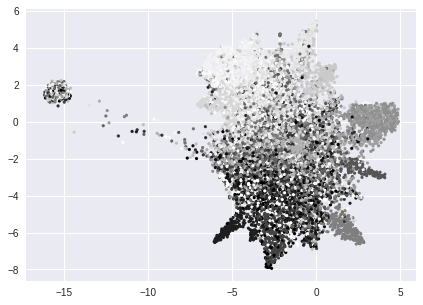

In [13]:
import umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()
